Phase Classification with Vowpal Wabbit
===

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../../annotation_data")

In [3]:
from phase import *
from vw import *

In [4]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
import sklearn.model_selection
import subprocess
import scipy

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

In [6]:
candidate_sites_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites"
valid_classification_sites_filename = os.path.join(candidate_sites_working_dir, "valid_classification_sites_filtered.txt")
with open(valid_classification_sites_filename, 'r') as infile:
    valid_sites = [int(line.strip()) for line in infile.readlines() if line.strip() != ""]
len(valid_sites)

4946

In [7]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/phases/vw"
assert os.path.exists(working_dir)

In [8]:
phase_named_labels = get_phase_named_labels()
phase_named_labels

'pretreatment,treatment,end_of_life,cured'

In [9]:
phase_code_map = {"pretreatment": "PT", "treatment": "T", "end_of_life": "EOL", "cured": "NED"}

In [9]:
annotated_df = get_annotated_phase_df()
len(annotated_df)

0it [00:00, ?it/s]

21it [00:05,  3.92it/s]


Site 135571 lacks 302 journals with phase annotations; http://127.0.0.1:5000/siteId/135571
It will be excluded unless the whole site is coded for phases!


51it [00:14,  3.58it/s]


Site 186533 lacks 118 journals with phase annotations; http://127.0.0.1:5000/siteId/186533
It will be excluded unless the whole site is coded for phases!


155it [00:57,  2.70it/s]


Site 722429 lacks 2 journals with phase annotations; http://127.0.0.1:5000/siteId/722429
It will be excluded unless the whole site is coded for phases!


162it [00:59,  2.73it/s]


Site 818475 lacks 5 journals with phase annotations; http://127.0.0.1:5000/siteId/818475
It will be excluded unless the whole site is coded for phases!


167it [01:01,  2.72it/s]

1 non-trivial journals did not have annotations on site 826591 and were skipped.


185it [01:08,  2.69it/s]

2 non-trivial journals did not have annotations on site 857627 and were skipped.


189it [01:10,  2.70it/s]


Site 864283 lacks 7 journals with phase annotations; http://127.0.0.1:5000/siteId/864283
It will be excluded unless the whole site is coded for phases!
1 non-trivial journals did not have annotations on site 866641 and were skipped.


213it [01:19,  2.67it/s]

1 non-trivial journals did not have annotations on site 912713 and were skipped.


228it [01:25,  2.68it/s]

1 non-trivial journals did not have annotations on site 1026937 and were skipped.


229it [01:25,  2.66it/s]

1 non-trivial journals did not have annotations on site 1028140 and were skipped.


231it [01:26,  2.66it/s]

2 non-trivial journals did not have annotations on site 1031202 and were skipped.


237it [01:28,  2.68it/s]


9336

In [ ]:
annotated_df.head(n=1)

In [11]:
full_df = add_sites_to_phase_df(annotated_df, valid_sites)
len(full_df)

100%|██████████| 4946/4946 [03:04<00:00, 26.84it/s]


Skipped 172 sites that were found already in the dataframe.


158109

In [12]:
full_df.reset_index(drop=True, inplace=True)

In [13]:
add_time_since_prev_journal_column(full_df)

100%|██████████| 4977/4977 [00:04<00:00, 1074.40it/s]

Site 1001818 only has a single valid journal, which may indicate an issue: http://127.0.0.1:5000/siteId/1001818


In [14]:
full_df.reset_index(drop=True, inplace=True)

In [ ]:
full_df.sample(n=2)

In [10]:
full_df_filepath = os.path.join(working_dir, "full_df.pkl")

In [17]:
full_df.to_pickle(full_df_filepath)

In [11]:
full_df = pd.read_pickle(full_df_filepath)

In [12]:
len(full_df)

158109

## CSOAA Model

In [16]:
annotated_df = full_df[full_df.is_annotated]
len(annotated_df)

9336

In [20]:
validation_pct = 0.2
annotated_sites = set(annotated_df.site_id)
validation_site_count = int(len(annotated_sites) * validation_pct)
print(f"Choosing {validation_site_count}/{len(annotated_sites)} sites for validation.")
validation_site_ids = random.sample(annotated_sites, validation_site_count)
validation_site_ids[:3]

Choosing 40/203 sites for validation.


[149905, 397252, 306606]

In [21]:
%%time
vw_train_filepath, vw_test_filepath, holdout_after = \
    format_phase_df_as_multiclass(full_df, working_dir, 
                                  validation_site_ids=validation_site_ids, 
                                  include_unannotated=False)
print(f"Should holdout after {holdout_after}.")

Wrote 9336 lines (7792 train, 1544 validation) to '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/phases/vw/phase_csoaa_default.train'.
Should holdout after 7792.
CPU times: user 16.5 s, sys: 196 ms, total: 16.7 s
Wall time: 16.9 s


In [ ]:
!head -c 1024 {vw_train_filepath}

In [23]:
# Train the model
vw_model_file=os.path.join(working_dir, "phase_csoaa_default.model")
num_classes = len(phase_named_labels)
train_file_command = f"vw -k -c -b 27 --csoaa {num_classes} -d {vw_train_filepath} -f {vw_model_file} --passes 20 --holdout_after {holdout_after} --named_labels {phase_named_labels} --ngram 2 --skips 1"
proc = subprocess.run(train_file_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

In [24]:
# Predict on the labeled data
train_pred_file =  os.path.join(working_dir, "phase_csoaa_default_train.pred")
train_raw_pred_file = os.path.join(working_dir, "phase_csoaa_default_train.pred.raw")
predict_train_command = f"vw -t -i {vw_model_file} -p {train_pred_file} -d {vw_train_filepath} -r {train_raw_pred_file}"
proc = subprocess.run(predict_train_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

In [18]:
# Predict on the unlabeled data
test_pred_file =  os.path.join(working_dir, "phase_csoaa_default_test.pred")
test_raw_pred_file = os.path.join(working_dir, "phase_csoaa_default_test.pred.raw")
predict_test_command = f"vw -t -i {vw_model_file} -p {test_pred_file} -d {vw_test_filepath} -r {test_raw_pred_file}"
proc = subprocess.run(predict_test_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

In [25]:
train_preds = read_raw_multiclass_phase_preds(train_raw_pred_file)
assert len(train_preds) == len(full_df[full_df.is_annotated])

In [26]:
annotated = full_df[full_df.is_annotated].merge(train_preds, how="left", validate="one_to_one")
annotated = annotated.iloc[holdout_after+1:]
# Verify that predictions for all annotations were merged into this dataframe
for col in annotated.columns:
    if col.endswith("_pred"):
        na_count = annotated[col].isna().sum()
        # print(col, na_count)
        assert na_count == 0, f"{col} NAs: {na_count}"
annotated.reset_index(drop=True, inplace=True)

In [27]:
# build y_true matrix (n_samples,n_classes)
# (slow/old method)
n_samples = len(annotated)
n_classes = len(phase_labels)
y_true = np.zeros((n_samples, n_classes))
for i in range(len(annotated)):
    row = annotated.iloc[i]
    for j, phase_label in enumerate(phase_labels):
        if row[phase_label + "_score"] > 0.5:
            y_true[i,j] = 1
y_true.shape

(1543, 4)

In [28]:
# build y_true matrix (n_samples,n_classes)
n_samples = len(annotated)
n_classes = len(phase_labels)
y_train_score = annotated.loc[range(n_samples), [phase_label + "_score" for phase_label in phase_labels]].values
y_true = (y_train_score > 0.5).astype(int)
y_true.shape

(1543, 4)

In [29]:
# build y_score matrix (n_samples,n_classes)
n_samples = len(annotated)
n_classes = len(phase_labels)
y_score = np.zeros((n_samples, n_classes))
error_count = 0
for i in range(len(annotated)):
    row = annotated.iloc[i]
    for j, phase_label in enumerate(phase_labels):
        score = row[phase_label + "_pred"]
        if not np.isfinite(score):
            print(row)
            y_score[i,j] = -1.0
            error_count += 1
        else:
            y_score[i,j] = score #1 - max(min(score, 1), 0)
assert np.isfinite(y_score).all()
y_score.shape, error_count

((1543, 4), 0)

In [30]:
y_score_raw = annotated.loc[range(n_samples), [phase_label + "_pred" for phase_label in phase_labels]].values
y_score_1 = 1 - np.clip(y_score_raw, 0, 1)
y_score_2 = 1 - ((y_score_raw - y_score_raw.min(0)) / y_score_raw.ptp(0))
print(y_score_raw.shape, y_score_1.shape, y_score_2.shape)
assert y_score_1.shape == y_score_2.shape
y_score = y_score_1
assert np.isfinite(y_score).all()
sklearn.metrics.roc_auc_score(y_true, y_score_1), sklearn.metrics.roc_auc_score(y_true, y_score_2)

(1543, 4) (1543, 4) (1543, 4)


(0.9652801501898807, 0.9613447293771091)

In [31]:
#y_score_norm = (y_score - y_score.min(0)) / y_score.ptp(0)
#y_score_norm = 1 - y_score_norm
#print(y_score_norm.ptp(), y_score_norm.min(), y_score_norm.max())
#assert np.isclose(y_score_norm.ptp(), 1), y_score_norm.ptp()
#sklearn.metrics.roc_auc_score(y_true, y_score_norm)

In [32]:
thresholds = np.linspace(0, 1, num=50)
scores = []
class_f2_score_mat = np.zeros((len(thresholds), n_classes))
for i, threshold in enumerate(thresholds):
    y_pred = (y_score > threshold).astype(int)
    
    class_f2_scores = np.array(sklearn.metrics.fbeta_score(y_true, y_pred, 2, average=None))
    class_f2_score_mat[i,:] = class_f2_scores
    
    macro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='macro')
    micro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='micro')
    weighted_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='weighted')
    samples_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='samples')
    scores.append((macro_f2_score, micro_f2_score, weighted_f2_score, samples_f2_score))
class_f2_score_mat.shape

/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted sampl

(50, 4)

Micro max threshold: 0.2857142857142857
Macro max threshold: 0.4897959183673469


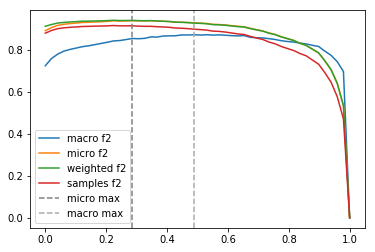

In [33]:
scores = np.array(scores)
plt.plot(thresholds, scores[:,0], label="macro f2")
plt.plot(thresholds, scores[:,1], label="micro f2")
plt.plot(thresholds, scores[:,2], label="weighted f2")
plt.plot(thresholds, scores[:,3], label="samples f2")

micro_max = thresholds[scores.argmax(0)[1]]
print("Micro max threshold:", micro_max)
plt.axvline(micro_max, color="gray", linestyle="--", label="micro max")

macro_max = thresholds[scores.argmax(0)[0]]
print("Macro max threshold:", macro_max)
plt.axvline(macro_max, color="darkgray", linestyle="--", label="macro max")

plt.legend()
plt.show()

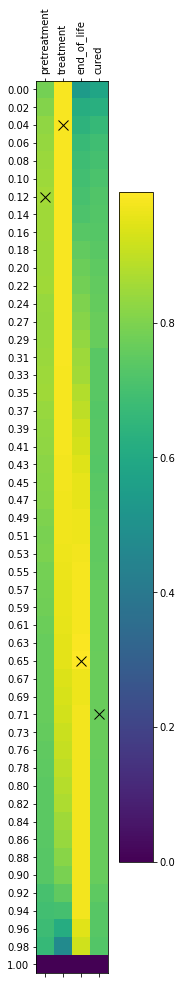

[('communicating', 0.12244897959183673),
 ('info_filtering', 0.04081632653061224),
 ('clinical_decisions', 0.6530612244897959),
 ('preparation', 0.7142857142857142)]

In [34]:
# visualize the per-class f2 score
plt.matshow(class_f2_score_mat)
plt.yticks(np.arange(0,len(thresholds)), ["%.2f" % th for th in thresholds])
plt.xticks(np.arange(0,len(phase_labels)), phase_labels, rotation=90)
plt.colorbar()

for i, index in enumerate(class_f2_score_mat.argmax(axis=0)):
    plt.plot(i, index, color='black', marker='x', markersize=10)

plt.show()

# compute the threshold that maximizes F2 score for each class separately
max_per_class_thresholds = np.array([thresholds[i] for i in class_f2_score_mat.argmax(axis=0)])
list(zip(responsibility_labels, max_per_class_thresholds))

In [35]:
# rather than using a single threshold, we instead use a per-class threshold
y_pred_per_class = (y_score >= max_per_class_thresholds).astype(int)
print("Proportion of Validation Samples Assigned Each Phase")
print("Phase                    % Pred  % True")
print("="*60)
for resp_label, pct_assigned_positive, pct_true in zip(phase_labels, 
                                             list(np.sum(y_pred_per_class, axis=0) / y_pred_per_class.shape[0]),
                                             list(np.sum(y_true, axis=0) / y_pred_per_class.shape[0])):
    print(f"{resp_label:24} {pct_assigned_positive:6.2f}  {pct_true:6.2f}")
print()

macro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='macro')
micro_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='micro')
weighted_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='weighted')
samples_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_per_class, 2, average='samples')
print("F2-score under different averaging conditions")
print("Macro Micro Weighted Samples")
print("="*30)
print(f"{macro_f2_score:5.2f} {micro_f2_score:5.2f} {weighted_f2_score:8.2f} {samples_f2_score:7.2f}")
print()

print(sklearn.metrics.classification_report(y_true, y_pred_per_class, target_names=phase_labels))

y_pred_per_class = (y_score >= 0.5).astype(int)
print("Proportion of Validation Samples Assigned Each Phase (using a global 0.5 threshold)")
print("Phase                    % Pred  % True")
print("="*60)
for resp_label, pct_assigned_positive, pct_true in zip(phase_labels, 
                                             list(np.sum(y_pred_per_class, axis=0) / y_pred_per_class.shape[0]),
                                             list(np.sum(y_true, axis=0) / y_pred_per_class.shape[0])):
    print(f"{resp_label:24} {pct_assigned_positive:6.2f}  {pct_true:6.2f}")
print()

Proportion of Validation Samples Assigned Each Phase
Phase                    % Pred  % True
pretreatment               0.20    0.15
treatment                  0.81    0.75
end_of_life                0.02    0.02
cured                      0.06    0.08

F2-score under different averaging conditions
Macro Micro Weighted Samples
 0.90  0.95     0.95    0.92

              precision    recall  f1-score   support

pretreatment       0.69      0.91      0.78       230
   treatment       0.93      1.00      0.96      1164
 end_of_life       0.97      1.00      0.98        32
       cured       0.99      0.73      0.84       125

 avg / total       0.90      0.96      0.93      1551

Proportion of Validation Samples Assigned Each Phase (using a global 0.5 threshold)
Phase                    % Pred  % True
pretreatment               0.13    0.15
treatment                  0.78    0.75
end_of_life                0.02    0.02
cured                      0.07    0.08



/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [257]:
# save the y_score and the thresholds, along with the classes
classes_filepath = os.path.join(working_dir, 'classes.npy')
np.save(classes_filepath, np.array(phase_labels))
y_true_filepath = os.path.join(working_dir, 'y_true.npy')
np.save(y_true_filepath, y_true)
y_score_filepath = os.path.join(working_dir, 'y_score.npy')
np.save(y_score_filepath, y_score)
thresholds_filepath = os.path.join(working_dir, 'class_thresholds.npy')
np.save(thresholds_filepath, max_per_class_thresholds)
print("Finished saving.")

Finished saving.


## Boostrapping and Parameter Search

In [13]:
def train_model(annotated_df, validation_site_ids, model_label):
    if validation_site_ids is None:
        validation_pct = 0.2
        annotated_sites = set(annotated_df.site_id)
        validation_site_count = int(len(annotated_sites) * validation_pct)
        print(f"Choosing {validation_site_count}/{len(annotated_sites)} sites for validation.")
        validation_site_ids = random.sample(annotated_sites, validation_site_count)
    
    # Format the training file
    vw_train_filepath, vw_test_filepath, holdout_after = \
    format_phase_df_as_multiclass(full_df, working_dir, 
                                  validation_site_ids=validation_site_ids, 
                                  include_unannotated=False)
    print(f"Holding out after {holdout_after} training lines.")
    
    # Train the model
    vw_model_file=os.path.join(working_dir, "phase_csoaa_default.model")
    num_classes = len(phase_labels)
    train_file_command = f"vw -k -c -b 27 --csoaa {num_classes} -d {vw_train_filepath} -f {vw_model_file} --passes 20 --holdout_after {holdout_after} --named_labels {phase_named_labels} --ngram 2 --skips 1"
    proc = subprocess.run(train_file_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    print("Model trained.")
    
    # Predict on the labeled data
    train_pred_file =  os.path.join(working_dir, "phase_csoaa_default_train.pred")
    train_raw_pred_file = os.path.join(working_dir, "phase_csoaa_default_train.pred.raw")
    predict_train_command = f"vw -t -i {vw_model_file} -p {train_pred_file} -d {vw_train_filepath} -r {train_raw_pred_file}"
    proc = subprocess.run(predict_train_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    print("Predictions generated.")
    
    # Merge in the predictions with the true scores
    train_preds = read_raw_multiclass_phase_preds(train_raw_pred_file)
    annotated = annotated_df.merge(train_preds, how="left", validate="one_to_one")
    annotated = annotated.iloc[holdout_after+1:]
    # Verify that predictions for all annotations were merged into this dataframe
    for col in annotated.columns:
        if col.endswith("_pred"):
            na_count = annotated[col].isna().sum()
            assert na_count == 0, f"{col} NAs: {na_count}"
    annotated.reset_index(drop=True, inplace=True)
    
    # Build y_true matrix (n_samples,n_classes)
    n_samples = len(annotated)
    n_classes = len(phase_labels)
    y_train_score = annotated.loc[range(n_samples), [phase_label + "_score" for phase_label in phase_labels]].values
    y_true = (y_train_score > 0.5).astype(int)
    
    # Build y_score matrix (n_samples,n_classes)
    y_score_raw = annotated.loc[range(n_samples), [phase_label + "_pred" for phase_label in phase_labels]].values
    y_score = 1 - np.clip(y_score_raw, 0, 1)
    assert np.isfinite(y_score).all()
    assert y_score.shape == y_true.shape
    print("Predictions merged and normalized.")
    
    # Compute f2 score at various thresholds
    thresholds = np.linspace(0, 1, num=50)
    class_f2_score_mat = np.zeros((len(thresholds), n_classes))
    for i, threshold in enumerate(thresholds):
        y_pred = (y_score > threshold).astype(int)
        class_f2_scores = np.array(sklearn.metrics.fbeta_score(y_true, y_pred, 2, average=None))
        class_f2_score_mat[i,:] = class_f2_scores
        
    # compute the threshold that maximizes F2 score for each class separately
    max_per_class_thresholds = np.array([thresholds[i] for i in class_f2_score_mat.argmax(axis=0)])
    print("Decision thresholds computed.")
    
    # Compute y_pred from the chosen thresholds
    y_pred = (y_score >= max_per_class_thresholds).astype(int)
    y_pred_default = (y_score >= 0.5).astype(int)

    # Compute metrics of interest
    #weighted_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred, 2, average='weighted')
    #class_f2_scores = np.array(sklearn.metrics.fbeta_score(y_true, y_pred, 2, average=None))
    #roc_auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    weighted_f2_score = sklearn.metrics.fbeta_score(y_true, y_pred_default, 2, average='weighted')
    class_f2_scores = np.array(sklearn.metrics.fbeta_score(y_true, y_pred_default, 2, average=None))
    weighted_precision_score = sklearn.metrics.precision_score(y_true, y_pred_default, average='weighted')
    class_precision_scores = np.array(sklearn.metrics.precision_score(y_true, y_pred_default, average=None))
    weighted_recall_score = sklearn.metrics.recall_score(y_true, y_pred_default, average='weighted')
    class_recall_scores = np.array(sklearn.metrics.recall_score(y_true, y_pred_default, average=None))

    
    # Generate a classification report
    #classification_report = sklearn.metrics.classification_report(y_true, y_pred, target_names=phase_labels)
    print(f"Finished training and evaluating model '{model_label}'.")
    
    return weighted_f2_score, weighted_precision_score, weighted_recall_score, class_f2_scores, class_precision_scores, class_recall_scores

In [ ]:
weighted_f2_score, weighted_precision_score, weighted_recall_score, class_f2_scores, class_precision_scores, class_recall_scores = train_model(annotated_df, None, "single run")

In [ ]:
print(f"{'Phase':20}  Pre   Rec   F2  ")
print("="*40)
for i, phase_label in enumerate(phase_labels): 
    print(f"{phase_label:20}  {class_precision_scores[i]:.2f}  {class_recall_scores[i]:.2f}  {class_f2_scores[i]:.2f}")
print(f"{'Mean':20}  {weighted_precision_score:.2f}  {weighted_recall_score:.2f}  {weighted_f2_score:.2f}")

In [264]:
# how different are the custom-thresholded f2 scores from the default f2 scores?
np.abs(class_f2_scores - class_f2_scores_default)

array([0.00896545, 0.01085998, 0.03035714, 0.03102455])

In [37]:
%%capture --no-stderr --no-display kfold_cv_stdout
# k-Fold cross-validation
k = 10
annotated_sites = np.array(list(set(annotated_df.site_id)))
kf = sklearn.model_selection.KFold(n_splits=k)

results = []

index = 0
for train_indices, val_indices in tqdm(kf.split(annotated_sites)):
    validation_site_ids = list(annotated_sites[val_indices])
    weighted_f2_score, class_f2_scores, roc_auc, max_per_class_thresholds, _ = \
        train_model(annotated_df, validation_site_ids, f"{k}-fold validation model {index}")
    results.append((weighted_f2_score, class_f2_scores, roc_auc, max_per_class_thresholds))
    index += 1
f2_scores = np.array([tup[0] for tup in results])
np.mean(f2_scores), np.std(f2_scores)

/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.9706399575420065, 0.016950042951098438)

(10, 4)
[0.19198865 0.30522829 0.07124612 0.20331489 0.11270777 0.23201667
 0.11932669 0.05076467 0.3315934  0.17813357]
[0.81632653 0.79591837 0.44897959 0.7755102  0.71428571 0.81632653
 0.6122449  0.65306122 0.83673469 0.63265306]
[0.30612245 0.12244898 0.26530612 0.24489796 0.46938776 0.2244898
 0.34693878 0.53061224 0.02040816 0.20408163]


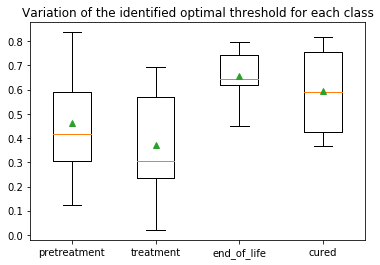

In [41]:
# k-Fold analysis of thresholds
thresholds = np.array([tup[3] for tup in results])
print(thresholds.shape)
print(thresholds.std(axis=1))
print(thresholds.max(axis=1))
print(thresholds.min(axis=1))
plt.boxplot(thresholds, labels=phase_labels, showmeans=True)

plt.title("Variation of the identified optimal threshold for each class")
plt.show()

In [265]:
%%capture --no-stderr --no-display bootstrap_stdout
bootstrap_results = []
bootstrap_n = 2
for i in tqdm(range(bootstrap_n)):
    weighted_f2_score, class_f2_scores, weighted_f2_score_default, class_f2_scores_default, roc_auc, max_per_class_thresholds, _ = \
        train_model(annotated_df, None, f"bootstrap run {i}")
    bootstrap_results.append((weighted_f2_score, class_f2_scores, weighted_f2_score_default, class_f2_scores_default, roc_auc, max_per_class_thresholds))
len(bootstrap_results)

  0%|          | 0/2 [00:00<?, ?it/s]/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 2/2 [01:09<00:00, 34.74s/it]


2

In [94]:
bootstrap_f2_scores = np.array([tup[0] for tup in bootstrap_results])
np.mean(bootstrap_f2_scores), np.std(bootstrap_f2_scores)

(0.9453927057726169, 0.017427197471497197)

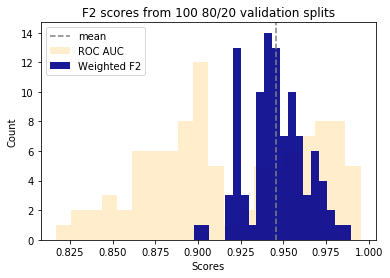

In [117]:
roc_auc_scores = np.array([tup[4] for tup in bootstrap_results])
plt.hist(roc_auc_scores, bins=20, alpha=0.2, label='ROC AUC', color='orange')
plt.hist(bootstrap_f2_scores, bins=20, alpha=0.9, label='Weighted F2', color='darkblue')
plt.axvline(np.mean(bootstrap_f2_scores), linestyle='--', color='gray', label='mean')
plt.title(f"F2 scores from {len(bootstrap_f2_scores)} 80/20 validation splits")
plt.xlabel("Scores")
plt.ylabel("Count")
plt.legend()
plt.show()

### 50 20-fold CV code

In [17]:
%%capture --no-stderr --no-display kfold_stdout
# Runs n instances of k-fold cross-validation
# Expected time when n = 50 and k = 20 is ~8 hours
n_results = []
n = 50
k = 20
for i in tqdm(range(n)):
    annotated_sites = np.array(list(set(annotated_df.site_id)))
    kf = sklearn.model_selection.KFold(n_splits=k)
    kfold_results = []
    index = 0
    for train_indices, val_indices in kf.split(annotated_sites):
        validation_site_ids = list(annotated_sites[val_indices])
        weighted_f2_score, weighted_precision_score, weighted_recall_score, class_f2_scores, class_precision_scores, class_recall_scores = \
            train_model(annotated_df, validation_site_ids, f"{i} {k}-fold validation model {index}")
        kfold_results.append((weighted_f2_score, weighted_precision_score, weighted_recall_score, class_f2_scores, class_precision_scores, class_recall_scores))
        index += 1
    n_results.append(kfold_results)
len(n_results)

  0%|          | 0/50 [00:00<?, ?it/s]/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 50/50 [11:21:32<00:00, 817.85s/it]  


50

In [18]:
n_scores = np.zeros((n*k, 3 + 3*len(phase_labels)))
index = 0
for kfold_results in n_results:
    for tup in kfold_results:
        weighted_f2_score, weighted_precision_score, weighted_recall_score, class_f2_scores, class_precision_scores, class_recall_scores = tup
        n_scores[index, 0] = weighted_precision_score
        n_scores[index, 1] = weighted_recall_score
        n_scores[index, 2] = weighted_f2_score
        n_scores[index, 3:7] = class_precision_scores
        n_scores[index, 7:11] = class_recall_scores
        n_scores[index, 11:15] = class_f2_scores
        index += 1
n_scores_filepath = os.path.join(working_dir, "n_scores_notime.npy")
np.save(n_scores_filepath, n_scores)
print("Saved scores.")

Saved scores.


In [19]:
# Compute the precision, recall, and F2 score as will be reported in the paper

# cv_mean_scores is the same as n_scores but each of the CV runs is meaned to a single row
# this isn't necessary if we just end up taking the column-wise average, since all groups are the same size.
# it could be necessary in the future if we drop some class scores that aren't valid...
cv_mean_scores = np.zeros((n, 3 + 3*len(phase_labels)))
for j in range(n):
    kfold_scores = n_scores[j*k:j*k+k, :]
    cv_mean_scores[j,:] = np.mean(kfold_scores, axis=0)

print(f"{'Phase':20}  Pre   Rec   F2  ")
print("="*40)
for i, phase_label in enumerate(phase_labels):
    class_precision = np.mean(cv_mean_scores[:,3+i])
    class_recall = np.mean(cv_mean_scores[:,7+i])
    class_f2 = np.mean(cv_mean_scores[:,11+i])
    print(f"{phase_label:20}  {class_precision:.2f}  {class_recall:.2f}  {class_f2:.2f}")
print(f"{'Mean':20}  {np.mean(cv_mean_scores[:,0]):.2f}  {np.mean(cv_mean_scores[:,1]):.2f}  {np.mean(cv_mean_scores[:,2]):.2f}")

Phase                 Pre   Rec   F2  
pretreatment          0.92  0.95  0.94
treatment             0.96  0.99  0.98
end_of_life           0.56  0.96  0.80
cured                 0.86  0.86  0.86
Mean                  0.94  0.97  0.96


In [49]:
print(f"{'Phase':4}  Pre   Rec   F2  ")
print("="*40)
for i, phase_label in enumerate(phase_labels):
    phase_code = phase_code_map[phase_label]
    class_precision = np.mean(cv_mean_scores[:,3+i])
    class_recall = np.mean(cv_mean_scores[:,7+i])
    class_f2 = np.mean(cv_mean_scores[:,11+i])
    print(f"{phase_code:4} & {class_precision:.2f} & {class_recall:.2f} & {class_f2:.2f} \\\\")
print(f"{'Mean':4} & {np.mean(cv_mean_scores[:,0]):.2f} & {np.mean(cv_mean_scores[:,1]):.2f} & {np.mean(cv_mean_scores[:,2]):.2f} \\\\")

Phase  Pre   Rec   F2  
PT   & 0.91 & 0.95 & 0.94 \\
T    & 0.96 & 0.99 & 0.98 \\
EOL  & 0.55 & 0.96 & 0.80 \\
NED  & 0.86 & 0.86 & 0.86 \\
Mean & 0.94 & 0.97 & 0.96 \\


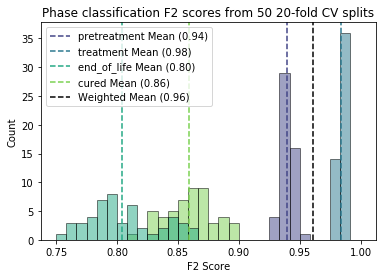

In [20]:
f2_scores_list = []
colors = []
labels = []
for i, phase_label in enumerate(phase_labels):
    f2_scores = []
    for j in range(n):
        kfold_scores = n_scores[j*k:j*k+k, 11+i]
        f2_scores.append(np.mean(kfold_scores))
    f2_scores_list.append(f2_scores)
    colors.append(plt.get_cmap('viridis')(0.2 + i*0.2))
    labels.append(f'{phase_label} Mean ({np.mean(f2_scores):0.2f})')
#plt.hist(f2_scores_list, bins=10, alpha=1, color=colors, range=(0.8, 1))
for i in [1, 0, 3, 2]:  # Manually define a draw ordering to minimize overlap
    plt.hist(f2_scores_list[i], bins=30, alpha=0.5, color=colors[i], range=(0.75, 1), edgecolor='black')
for i in range(len(phase_labels)):
    plt.axvline(np.mean(f2_scores_list[i]), linestyle='--', color=colors[i], label=labels[i])
weighted_global_mean = np.mean(n_scores[:,2])
plt.axvline(weighted_global_mean, linestyle='--', color='black', label=f'Weighted Mean ({weighted_global_mean:.2f})')
plt.title(f"Phase classification F2 scores from {n} {k}-fold CV splits")
plt.xlabel("F2 Score")
plt.ylabel("Count")
plt.legend()
phase_figure_filepath = os.path.join(working_dir, f"phase_cv_results_{k}fold_{n}.pdf")
plt.savefig(phase_figure_filepath, dpi=200)
plt.show()

#### Ablation: t-test for uncertainty costs vs no cost adjustment

In [51]:
n_scores_filepath = os.path.join(working_dir, "n_scores.npy")
n_scores = np.load(n_scores_filepath)
cost_cv_mean_scores = np.zeros((n, 3 + 3*len(phase_labels)))
for j in range(n):
    kfold_scores = n_scores[j*k:j*k+k, :]
    cost_cv_mean_scores[j,:] = np.mean(kfold_scores, axis=0)
    
n_scores_filepath = os.path.join(working_dir, "n_scores_nocost.npy")
n_scores = np.load(n_scores_filepath)
nocost_cv_mean_scores = np.zeros((n, 3 + 3*len(phase_labels)))
for j in range(n):
    kfold_scores = n_scores[j*k:j*k+k, :]
    nocost_cv_mean_scores[j,:] = np.mean(kfold_scores, axis=0)

cost_f2_scores = cost_cv_mean_scores[:,2]
nocost_f2_scores = nocost_cv_mean_scores[:,2]
np.mean(cost_f2_scores), np.mean(nocost_f2_scores)

(0.9605387383270154, 0.9617621407651639)

In [55]:
scipy.stats.ttest_ind(nocost_f2_scores, cost_f2_scores, equal_var=False)

Ttest_indResult(statistic=1.4809134962575408, pvalue=0.14207778298012375)

#### Ablation: t-test for time features vs no time features

In [21]:
n_scores_filepath = os.path.join(working_dir, "n_scores.npy")
n_scores = np.load(n_scores_filepath)
time_cv_mean_scores = np.zeros((n, 3 + 3*len(phase_labels)))
for j in range(n):
    kfold_scores = n_scores[j*k:j*k+k, :]
    time_cv_mean_scores[j,:] = np.mean(kfold_scores, axis=0)
    
n_scores_filepath = os.path.join(working_dir, "n_scores_notime.npy")
n_scores = np.load(n_scores_filepath)
notime_cv_mean_scores = np.zeros((n, 3 + 3*len(phase_labels)))
for j in range(n):
    kfold_scores = n_scores[j*k:j*k+k, :]
    notime_cv_mean_scores[j,:] = np.mean(kfold_scores, axis=0)

time_f2_scores = time_cv_mean_scores[:,2]
notime_f2_scores = notime_cv_mean_scores[:,2]
np.mean(time_f2_scores), np.mean(notime_f2_scores)

(0.9605387383270154, 0.9609781960480059)

In [24]:
scipy.stats.ttest_ind(notime_f2_scores, time_f2_scores, equal_var=False)

Ttest_indResult(statistic=0.5882797657185598, pvalue=0.5577148126258756)

#### Visualizations that used an older format of the n_scores matrix:

In [274]:
#n_results = [[(0.8, np.array([1, 2, 3, 4]), 0.9, "") for i in range(k)] for j in range(n)]
n_scores = np.zeros((n*k, 2 + len(phase_labels) + 1 + len(phase_labels) ))
index = 0
for kfold_results in n_results:
    for tup in kfold_results:
        weighted_f2_score, class_f2_scores, roc_auc, weighted_f2_score_default, class_f2_scores_default, max_per_class_thresholds = tup
        n_scores[index, 0] = weighted_f2_score
        n_scores[index, 1] = roc_auc
        n_scores[index, 2:6] = class_f2_scores
        n_scores[index, 6] = weighted_f2_score_default
        n_scores[index, 7:11] = class_f2_scores_default
        index += 1
n_scores_filepath = os.path.join(working_dir, "n_scores.npy")
np.save(n_scores_filepath, n_scores)
print("Saved scores.")

Saved scores.


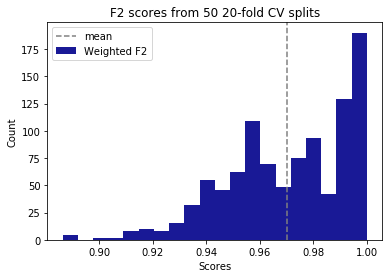

In [275]:
f2_scores = n_scores[:,0]
plt.hist(f2_scores, bins=20, alpha=0.9, label='Weighted F2', color='darkblue')
plt.axvline(np.mean(f2_scores), linestyle='--', color='gray', label='mean')
plt.title(f"F2 scores from {n} {k}-fold CV splits")
plt.xlabel("Scores")
plt.ylabel("Count")
plt.legend()
plt.show()

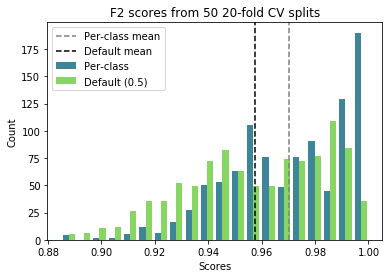

In [289]:
f2_scores = n_scores[:,0]
f2_scores_default = n_scores[:,6]
plt.hist([f2_scores, f2_scores_default], bins=20, alpha=0.9, 
         label=['Per-class', 'Default (0.5)'], 
         color=[plt.get_cmap('viridis')(0.4), plt.get_cmap('viridis')(0.8)])
plt.axvline(np.mean(f2_scores), linestyle='--', color='gray', label='Per-class mean')
plt.axvline(np.mean(f2_scores_default), linestyle='--', color='black', label='Default mean')
plt.title(f"F2 scores from {n} {k}-fold CV splits")
plt.xlabel("Scores")
plt.ylabel("Count")
plt.legend()
plt.show()

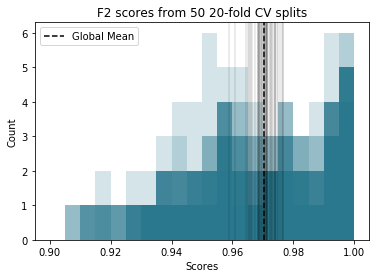

In [276]:
f2_scores = n_scores[:,0]
for i in range(n):
    kfold_scores = n_scores[i*k:i*k+k, 0]
    assert len(kfold_scores) == k
    plt.hist(kfold_scores, bins=20, alpha=0.2, color=plt.get_cmap('viridis')(0.4), range=(0.9, 1))
    plt.axvline(np.mean(kfold_scores), linestyle='-', color='black', alpha=0.1)
plt.axvline(np.mean(f2_scores), linestyle='--', color='black', label='Global Mean')
plt.title(f"F2 scores from {n} {k}-fold CV splits")
plt.xlabel("Scores")
plt.ylabel("Count")
plt.legend()
plt.show()

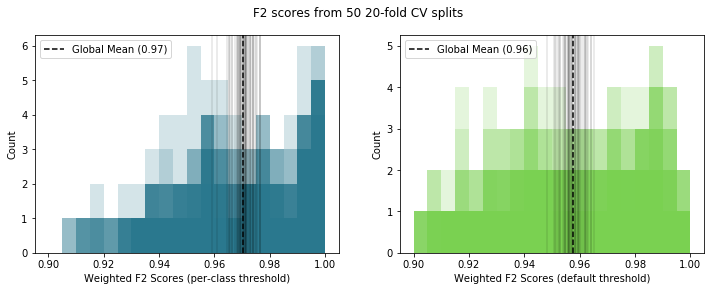

In [287]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle(f"F2 scores from {n} {k}-fold CV splits")

plt.sca(axs[0])
f2_scores = n_scores[:,0]
for i in range(n):
    kfold_scores = n_scores[i*k:i*k+k, 0]
    assert len(kfold_scores) == k
    plt.hist(kfold_scores, bins=20, alpha=0.2, color=plt.get_cmap('viridis')(0.4), range=(0.9, 1))
    plt.axvline(np.mean(kfold_scores), linestyle='-', color='black', alpha=0.1)
plt.axvline(np.mean(f2_scores), linestyle='--', color='black', label=f'Global Mean ({np.mean(f2_scores):.2f})')
#plt.title(f"F2 scores from {n} {k}-fold CV splits")
plt.xlabel("Weighted F2 Scores (per-class threshold)")
plt.ylabel("Count")
plt.legend()

plt.sca(axs[1])
f2_scores = n_scores[:,6]
for i in range(n):
    kfold_scores = n_scores[i*k:i*k+k, 6]
    assert len(kfold_scores) == k
    plt.hist(kfold_scores, bins=20, alpha=0.2, color=plt.get_cmap('viridis')(0.8), range=(0.9, 1))
    plt.axvline(np.mean(kfold_scores), linestyle='-', color='black', alpha=0.1)
plt.axvline(np.mean(f2_scores), linestyle='--', color='black', label=f'Global Mean ({np.mean(f2_scores):.2f})')
plt.xlabel("Weighted F2 Scores (default threshold)")
plt.ylabel("Count")
plt.legend()

plt.show()

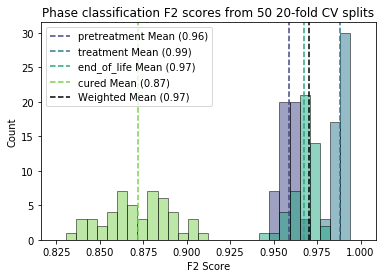

In [280]:
f2_scores_list = []
colors = []
labels = []
for i, phase_label in enumerate(phase_labels):
    f2_scores = []
    for j in range(n):
        kfold_scores = n_scores[j*k:j*k+k, 2+i]
        f2_scores.append(np.mean(kfold_scores))
    f2_scores_list.append(f2_scores)
    colors.append(plt.get_cmap('viridis')(0.2 + i*0.2))
    labels.append(f'{phase_label} Mean ({np.mean(f2_scores):0.2f})')
#plt.hist(f2_scores_list, bins=10, alpha=1, color=colors, range=(0.8, 1))
for i in [1, 0, 3, 2]:  # Manually define a draw ordering to minimize overlap
    plt.hist(f2_scores_list[i], bins=30, alpha=0.5, color=colors[i], range=(0.825, 1), edgecolor='black')
for i in range(len(phase_labels)):
    plt.axvline(np.mean(f2_scores_list[i]), linestyle='--', color=colors[i], label=labels[i])
plt.axvline(np.mean(n_scores[:,0]), linestyle='--', color='black', label=f'Weighted Mean ({np.mean(n_scores[:,0]):.2f})')
plt.title(f"Phase classification F2 scores from {n} {k}-fold CV splits")
plt.xlabel("F2 Score")
plt.ylabel("Count")
plt.legend()
phase_figure_filepath = os.path.join(working_dir, f"phase_cv_results_{k}fold_{n}.pdf")
plt.savefig(phase_figure_filepath, dpi=200)
plt.show()

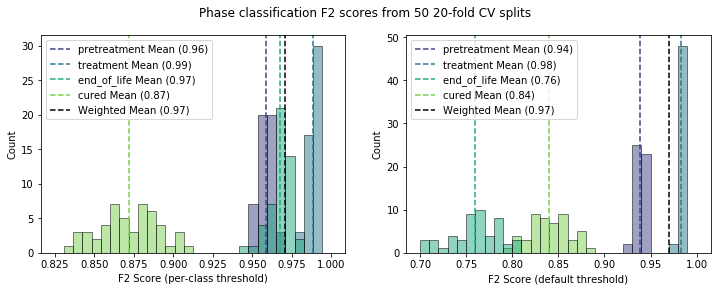

In [317]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle(f"Phase classification F2 scores from {n} {k}-fold CV splits")

plt.sca(axs[0])
f2_scores_list = []
colors = []
labels = []
for i, phase_label in enumerate(phase_labels):
    f2_scores = []
    for j in range(n):
        kfold_scores = n_scores[j*k:j*k+k, 2+i]
        f2_scores.append(np.mean(kfold_scores))
    f2_scores_list.append(f2_scores)
    colors.append(plt.get_cmap('viridis')(0.2 + i*0.2))
    labels.append(f'{phase_label} Mean ({np.mean(f2_scores):0.2f})')
#plt.hist(f2_scores_list, bins=10, alpha=1, color=colors, range=(0.8, 1))
for i in [1, 0, 3, 2]:  # Manually define a draw ordering to minimize overlap
    plt.hist(f2_scores_list[i], bins=30, alpha=0.5, color=colors[i], range=(0.825, 1), edgecolor='black')
for i in range(len(phase_labels)):
    plt.axvline(np.mean(f2_scores_list[i]), linestyle='--', color=colors[i], label=labels[i])
plt.axvline(np.mean(n_scores[:,0]), linestyle='--', color='black', label=f'Weighted Mean ({np.mean(n_scores[:,0]):.2f})')
plt.xlabel("F2 Score (per-class threshold)")
plt.ylabel("Count")
plt.legend()

plt.sca(axs[1])
f2_scores_list = []
colors = []
labels = []
for i, phase_label in enumerate(phase_labels):
    f2_scores = []
    for j in range(n):
        kfold_scores = n_scores[j*k:j*k+k, 7+i]
        f2_scores.append(np.mean(kfold_scores))
    f2_scores_list.append(f2_scores)
    colors.append(plt.get_cmap('viridis')(0.2 + i*0.2))
    labels.append(f'{phase_label} Mean ({np.mean(f2_scores):0.2f})')
for i in [1, 0, 3, 2]:  # Manually define a draw ordering to minimize overlap
    plt.hist(f2_scores_list[i], bins=30, alpha=0.5, color=colors[i], range=(0.7, 1), edgecolor='black')
for i in range(len(phase_labels)):
    plt.axvline(np.mean(f2_scores_list[i]), linestyle='--', color=colors[i], label=labels[i])
plt.axvline(np.mean(n_scores[:,0]), linestyle='--', color='black', label=f'Weighted Mean ({np.mean(n_scores[:,0]):.2f})')
plt.xlabel("F2 Score (default threshold)")
plt.ylabel("Count")
plt.legend()

plt.show()

For each CV, the mean threshold and the variation among thresholds.
[0.45 0.33 0.61 0.48] [0.2  0.23 0.14 0.19]
[0.43 0.36 0.67 0.55] [0.21 0.21 0.13 0.2 ]
[0.43 0.35 0.62 0.45] [0.21 0.24 0.1  0.16]
[0.46 0.31 0.66 0.39] [0.19 0.19 0.12 0.19]
[0.52 0.32 0.59 0.49] [0.21 0.25 0.14 0.18]
[0.5  0.32 0.62 0.48] [0.17 0.22 0.12 0.17]
[0.45 0.41 0.64 0.45] [0.19 0.21 0.17 0.19]
[0.43 0.35 0.62 0.47] [0.19 0.21 0.14 0.14]
[0.48 0.34 0.63 0.43] [0.2  0.2  0.15 0.18]
[0.49 0.24 0.65 0.49] [0.2  0.22 0.11 0.17]
[0.41 0.29 0.64 0.44] [0.18 0.2  0.16 0.21]
[0.44 0.34 0.62 0.43] [0.22 0.25 0.16 0.19]
[0.43 0.31 0.62 0.45] [0.18 0.21 0.15 0.2 ]
[0.49 0.31 0.64 0.45] [0.18 0.23 0.16 0.19]
[0.46 0.44 0.65 0.48] [0.2  0.25 0.14 0.16]
[0.49 0.38 0.62 0.47] [0.2  0.2  0.15 0.13]
[0.48 0.35 0.64 0.48] [0.22 0.24 0.15 0.19]
[0.44 0.43 0.63 0.51] [0.19 0.25 0.11 0.19]
[0.43 0.33 0.62 0.45] [0.22 0.23 0.13 0.19]
[0.43 0.41 0.64 0.44] [0.21 0.22 0.14 0.16]
[0.44 0.33 0.6  0.49] [0.21 0.23 0.13 0.17]
[0.39 0.

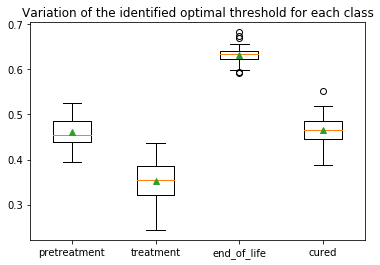

Global means and standard deviations:
pretreatment         0.46   0.20
treatment            0.35   0.22
end_of_life          0.63   0.13
cured                0.47   0.18


In [313]:
# what about the spread in the per-class thresholds?
print("For each CV, the mean threshold and the variation among thresholds.")
cv_mean_thresholds = np.zeros((n, n_classes))
cv_std_thresholds = np.zeros((n, n_classes))
for j, kfold_results in enumerate(n_results):
    kfold_thresholds = np.zeros((len(kfold_results), n_classes))
    for i, tup in enumerate(kfold_results):
        weighted_f2_score, class_f2_scores, roc_auc, weighted_f2_score_default, class_f2_scores_default, max_per_class_thresholds = tup
        kfold_thresholds[i,:] = max_per_class_thresholds
    print(f"{np.round(kfold_thresholds.mean(axis=0), 2)} {np.round(kfold_thresholds.std(axis=0), 2)}")
    mean_thresholds = kfold_thresholds.mean(axis=0)
    cv_mean_thresholds[j,:] = mean_thresholds
    cv_std_thresholds[j,:] = kfold_thresholds.std(axis=0)
        
# k-Fold analysis of thresholds
plt.boxplot(cv_mean_thresholds, labels=phase_labels, showmeans=True)
plt.title("Variation of the identified optimal threshold for each class")
plt.show()

print("Global means and standard deviations:")
for lab, m, sd in zip(phase_labels, cv_mean_thresholds.mean(axis=0), cv_std_thresholds.mean(axis=0)):
    print(f"{lab:20} {m:.2f}   {sd:.2f}")

## Predict on the test data

With a model trained on all of the training data.

In [43]:
# Select validation sites to set the thresholds
validation_pct = 0.2
annotated_df = full_df[full_df.is_annotated]
annotated_sites = set(annotated_df.site_id)
validation_site_count = int(len(annotated_sites) * validation_pct)
print(f"Choosing {validation_site_count}/{len(annotated_sites)} sites for validation.")
validation_site_ids = random.sample(annotated_sites, validation_site_count)

# Format the training file
vw_train_filepath, vw_test_filepath, holdout_after = \
format_phase_df_as_multiclass(full_df, working_dir, 
                              validation_site_ids=validation_site_ids,
                              identifier='full',
                              include_unannotated=True)
print(f"Holding out after {holdout_after} training lines.")

# Train the model
vw_model_file=os.path.join(working_dir, "phase_csoaa_full.model")
num_classes = len(phase_labels)
train_file_command = f"vw -k -c -b 28 --csoaa {num_classes} -d {vw_train_filepath} -f {vw_model_file} --passes 20 --holdout_after {holdout_after} --named_labels {phase_named_labels} --ngram 2 --skips 1"
proc = subprocess.run(train_file_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
print("Model trained.")

# Predict on the labeled data
train_pred_file =  os.path.join(working_dir, "phase_csoaa_full_train.pred")
train_raw_pred_file = os.path.join(working_dir, "phase_csoaa_full_train.pred.raw")
predict_train_command = f"vw -t -i {vw_model_file} -p {train_pred_file} -d {vw_train_filepath} -r {train_raw_pred_file}"
proc = subprocess.run(predict_train_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
print("Training predictions generated.")

# Predict on the unlabeled data
test_pred_file =  os.path.join(working_dir, "phase_csoaa_full_test.pred")
test_raw_pred_file = os.path.join(working_dir, "phase_csoaa_full_test.pred.raw")
predict_test_command = f"vw -t -i {vw_model_file} -p {test_pred_file} -d {vw_test_filepath} -r {test_raw_pred_file}"
proc = subprocess.run(predict_test_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
print("Testing predictions generated.")

Choosing 40/200 sites for validation.
Wrote 6921 lines (5310 train, 1611 validation) to '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/phases/vw/phase_csoaa_full.train'.
Wrote 151188 lines to '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/phases/vw/phase_csoaa_full.test.'
Holding out after 5310 training lines.
Model trained.
Training predictions generated.
Testing predictions generated.


In [20]:
train_pred_file =  os.path.join(working_dir, "phase_csoaa_full_train.pred")
train_raw_pred_file = os.path.join(working_dir, "phase_csoaa_full_train.pred.raw")
test_pred_file =  os.path.join(working_dir, "phase_csoaa_full_test.pred")
test_raw_pred_file = os.path.join(working_dir, "phase_csoaa_full_test.pred.raw")

In [22]:
# Merge in the predictions with the true scores
train_preds = read_raw_multiclass_phase_preds(train_raw_pred_file)
test_preds = read_raw_multiclass_phase_preds(test_raw_pred_file)
merged = full_df.merge(pd.concat([train_preds, test_preds]), how="left", validate="one_to_one")
merged.reset_index(drop=True, inplace=True)
assert len(merged) == len(full_df)
print("Predictions merged.")

# Verify that predictions for all journals were merged into this dataframe
for col in merged.columns:
    if col.endswith("_pred"):
        na_count = merged[col].isna().sum()
        assert na_count == 0, f"{col} NAs: {na_count}"

# Build y_score matrix (n_samples,n_classes)
n_samples = len(merged)
n_classes = len(phase_labels)
y_score_raw = merged.loc[range(n_samples), [phase_label + "_pred" for phase_label in phase_labels]].values
y_score = 1 - np.clip(y_score_raw, 0, 1)
assert np.isfinite(y_score).all()
print("Predictions merged and normalized.")
y_score.shape

Predictions merged.
Predictions merged and normalized.


(158109, 4)

In [112]:
# From the validation set, compute the threshold that maximizes validation score
annotated = merged[merged.site_id.isin(validation_site_ids)]
annotated.reset_index(drop=True, inplace=True)
print(f"Identified {len(annotated)} journals in the validation sites.")

# build y_true_val and y_score_val
n_samples = len(annotated)
n_classes = len(phase_labels)
y_train_score_val = annotated.loc[range(n_samples), [phase_label + "_score" for phase_label in phase_labels]].values
y_true_val = (y_train_score_val > 0.5).astype(int)
y_score_raw_val = annotated.loc[range(n_samples), [phase_label + "_pred" for phase_label in phase_labels]].values
y_score_val = 1 - np.clip(y_score_raw_val, 0, 1)
assert np.isfinite(y_true_val).all()
assert np.isfinite(y_score_val).all()
assert y_score_val.shape == y_true_val.shape
# Compute f2 score at various thresholds
thresholds = np.linspace(0, 1, num=100)
class_f2_score_mat = np.zeros((len(thresholds), n_classes))
for i, threshold in enumerate(thresholds):
    y_pred_val = (y_score_val > threshold).astype(int)
    class_f2_scores = np.array(sklearn.metrics.fbeta_score(y_true_val, y_pred_val, 2, average=None))
    class_f2_score_mat[i,:] = class_f2_scores

# compute the threshold that maximizes F2 score for each class separately
f2_maximizing_thresholds = np.array([thresholds[i] for i in class_f2_score_mat.argmax(axis=0)])
# alternately, don't do that at all, and just use the 0.5 decision threshold for all classes!
default_thresholds = np.array([0.5 for i in range(n_classes)])
#max_per_class_thresholds = (f2_maximizing_thresholds + default_thresholds) / 2
max_per_class_thresholds = default_thresholds

y_pred_val = (y_score_val >= max_per_class_thresholds).astype(int)
classification_report = sklearn.metrics.classification_report(y_true_val, y_pred_val, target_names=phase_labels)
print(classification_report)

# Compute y_pred from the chosen thresholds
y_pred = (y_score >= max_per_class_thresholds).astype(int)

list(zip(phase_labels, f2_maximizing_thresholds, max_per_class_thresholds))

Identified 1611 journals in the validation sites.
              precision    recall  f1-score   support

pretreatment       0.29      0.36      0.32       123
   treatment       0.88      0.94      0.91      1386
 end_of_life       0.17      0.20      0.18        41
       cured       0.04      0.06      0.05       101

 avg / total       0.77      0.82      0.80      1651



/panfs/roc/groups/3/srivbane/levon003/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[('pretreatment', 0.30303030303030304, 0.5),
 ('treatment', 0.020202020202020204, 0.5),
 ('end_of_life', 0.3434343434343435, 0.5),
 ('cured', 0.15151515151515152, 0.5)]

In [23]:
y_pred = (y_score >= 0.5).astype(int)
assert y_pred.shape == y_score.shape

In [24]:
# assign the predictions as new columns
for i, phase_label in enumerate(phase_labels):
    merged[phase_label + "_pred_label"] = y_pred[:, i]

In [25]:
# assign the true labels as new columns
for i, phase_label in enumerate(phase_labels):
    merged[phase_label + "_label"] = (merged[phase_label + "_score"] > 0.5).astype(int)

In [ ]:
merged.sample(n=2)

In [27]:
# To sanity-check the assignment process, we can check to make sure the accuracies on the labeled data are high
# If any of these are less than 0.7, that indicates a problem
annotated = merged[merged.is_annotated]
print(f"{'Phase':18}  {'Accuracy':>10}")
print("="*50)
for phase_label in phase_labels:
    acc = np.sum(annotated[phase_label + "_label"] == annotated[phase_label + "_pred_label"]) / len(annotated)
    print(f"{phase_label:18}  {acc:10.2f}")

Phase                 Accuracy
pretreatment              0.97
treatment                 0.96
end_of_life               0.99
cured                     0.96


In [28]:
annotated = merged[merged.is_annotated]
print(f"{'Phase':18}  {'% True':6}  {'% Pred':6}")
print("="*50)
for phase_label in phase_labels:
    true_proportion = np.sum(annotated[phase_label + "_label"]) / len(annotated)
    proportion_predicted = np.sum(merged[phase_label + "_pred_label"]) / len(merged)
    print(f"{phase_label:18}  {true_proportion:6.2f}  {proportion_predicted:6.2f}")

Phase               % True  % Pred
pretreatment          0.09    0.10
treatment             0.83    0.89
end_of_life           0.02    0.02
cured                 0.07    0.09


In [124]:
to_save = merged.drop(columns='journal_text')
print("Saving these columns:", to_save.columns.tolist())
all_predictions_filepath = os.path.join(working_dir, "vw_all_preds.pkl")
to_save.to_pickle(all_predictions_filepath)
print("Finished.")

Saving these columns: ['conflict_status', 'created_at', 'cured_score', 'end_of_life_score', 'is_annotated', 'journal_index', 'journal_oid', 'phases', 'pretreatment_score', 'site_id', 'treatment_score', 'seconds_since_previous_journal', 'cured_pred', 'end_of_life_pred', 'pretreatment_pred', 'treatment_pred', 'pretreatment_label', 'treatment_label', 'end_of_life_label', 'cured_label', 'pretreatment_pred_label', 'treatment_pred_label', 'end_of_life_pred_label', 'cured_pred_label']
Finished.


## Evaluating unannotated labeling correctness

Two primary questions of interest:
 - How many labelings are invalid?
 - How many site transitions are invalid?

### Invalid labelings

In [29]:
VALID_CLASS_LABELS = ([1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],
                  [1,1,0,0],[0,1,1,0],[0,1,0,1],[0,0,0,0])

In [30]:
preds = merged[~merged.is_annotated]
preds = preds.reset_index(drop=True)
pred_label_cols = [phase_label + "_pred_label" for phase_label in phase_labels]

y_pred = preds.loc[range(len(preds)), pred_label_cols].values
y_pred.shape

(151188, 4)

In [31]:
# Compute the percentage of journals that were assigned an illegal combination
valid_labelings = np.sum(np.apply_along_axis(lambda row: list(row) in VALID_CLASS_LABELS, 1, y_pred))
valid_labelings / len(preds)

0.9525028441410694

In [57]:
invalid_labeling_indices = np.apply_along_axis(lambda row: list(row) not in VALID_CLASS_LABELS, 1, y_pred)
assert len(preds[invalid_labeling_indices]) == len(preds) - valid_labelings
preds.loc[:, 'invalid_labeling'] = 0
preds.loc[invalid_labeling_indices, 'invalid_labeling'] = 1
len(preds[invalid_labeling_indices])

7181

In [ ]:
preds[invalid_labeling_indices].head(n=2)

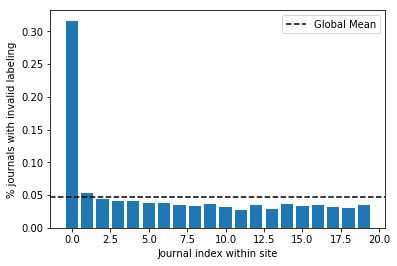

(0.0474971558589306, 0.31630730584048566)

In [170]:
# 31.6% (props[0] below) of first journal posts are assigned invalid phases
pct_invalid = len(preds[invalid_labeling_indices]) / len(preds)
props = []
for ji in range(20):
    pct_invalid_and_nth_journal = len(preds[(invalid_labeling_indices) & (preds.journal_index == ji)]) / len(preds[preds.journal_index == ji])
    props.append(pct_invalid_and_nth_journal)
plt.bar(range(len(props)), props)
plt.axhline(pct_invalid, linestyle='--', color='black', label="Global Mean")
plt.xlabel("Journal index within site")
plt.ylabel("% journals with invalid labeling")
plt.legend()
plt.show()
pct_invalid, props[0]

In [34]:
preds['journal_text_length'] = preds['journal_text'].apply(lambda text: len(text))

In [35]:
preds[['journal_index', 'seconds_since_previous_journal', 'journal_text_length', 'invalid_labeling']].corr()

,journal_index,seconds_since_previous_journal,journal_text_length,invalid_labeling
journal_index,1.000000,-0.027142,0.053458,0.025230
seconds_since_previous_journal,-0.027142,1.000000,0.054744,-0.021281
journal_text_length,0.053458,0.054744,1.000000,-0.133595
invalid_labeling,0.025230,-0.021281,-0.133595,1.000000


In [36]:
# The above isn't actually a fair comparison; 
# this gives the corr for seconds_since_previous_journal that includes only journals that actually have a previous journal
preds[preds.seconds_since_previous_journal > 0][['seconds_since_previous_journal', 'invalid_labeling']].corr()

,seconds_since_previous_journal,invalid_labeling
seconds_since_previous_journal,1.000000,-0.004284
invalid_labeling,-0.004284,1.000000


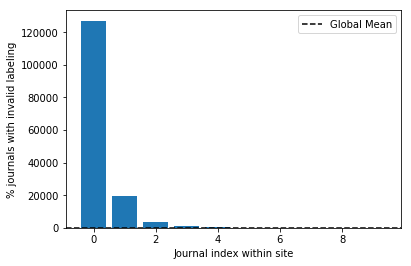

In [184]:
hist, bin_edges = np.histogram(preds.journal_text_length, range=(0, 30000))
plt.bar(range(len(hist)), hist)
plt.axhline(pct_invalid, linestyle='--', color='black', label="Global Mean")
plt.xlabel("Journal index within site")
plt.ylabel("% journals with invalid labeling")
plt.legend()
plt.show()

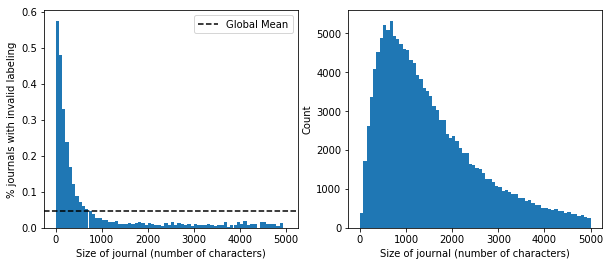

(0.0474971558589306, 0.574468085106383, 71)

In [235]:
# investigate the impact of journal length on invalid labeling
max_size = 5000

pct_invalid = len(preds[invalid_labeling_indices]) / len(preds)
props = []
left_edges = []
left_edge = None
for right_edge in np.linspace(0, max_size, 71):
    if left_edge is None:
        left_edge = right_edge
        continue
    total_in_bucket = len(preds[(preds.journal_text_length > left_edge) & (preds.journal_text_length <= right_edge)])
    if total_in_bucket > 0:
        pct = len(preds[(invalid_labeling_indices) & (preds.journal_text_length > left_edge) & (preds.journal_text_length <= right_edge)]) / total_in_bucket
    else:
        pct = 0
    props.append(pct)
    left_edges.append(int(left_edge))
    left_edge = right_edge
right_edges = np.linspace(0, max_size, 70)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(axs[0])
plt.bar(left_edges, props, align='edge', width=left_edges[1] - left_edges[0])
plt.axhline(pct_invalid, linestyle='--', color='black', label="Global Mean")
plt.xlabel("Size of journal (number of characters)")
plt.ylabel("% journals with invalid labeling")
plt.legend()

plt.sca(axs[1])
plt.hist(preds.journal_text_length, range=(0, max_size), bins=70, log=False)
plt.xlabel("Size of journal (number of characters)")
plt.ylabel("Count")

plt.show()
pct_invalid, props[0], left_edges[1]

In [227]:
# The percentage of invalidly-labeled journals that are less than 500 characters, the first journal, or both, respectively.
len(preds[(invalid_labeling_indices)&(preds.journal_text_length < 500)]) / len(preds[invalid_labeling_indices]), \
len(preds[(invalid_labeling_indices)&(preds.journal_index == 0)]) / len(preds[invalid_labeling_indices]), \
len(preds[(invalid_labeling_indices)&((preds.journal_index == 0)|(preds.journal_text_length < 500))]) / len(preds[invalid_labeling_indices])

(0.6091073666620248, 0.21041637654922712, 0.6928004456203871)

In [239]:
# 20.2% of journals with fewer than 500 characters are misclassified
# Journals with fewer than 500 characters represent 14.3% of all journals in the dataset
journal_text_length_threshold = 500
total_in_bucket = len(preds[preds.journal_text_length <= journal_text_length_threshold])
pct = len(preds[(invalid_labeling_indices) & (preds.journal_text_length <= journal_text_length_threshold)]) / total_in_bucket
pct, total_in_bucket / len(preds)

(0.20247895661825918, 0.14301399581977406)

#### Zero-phase analysis

Analysis of journals that are assigned zeros.

In [39]:
# Compute the percentage of journals that were assigned no phases
zero_phase_labelings = np.sum(np.apply_along_axis(lambda row: np.sum(row) == 0, 1, y_pred))
zero_phase_labelings / len(preds)

0.09041722888059898

In [42]:
zero_labeling_indices = np.apply_along_axis(lambda row: np.sum(row) == 0, 1, y_pred)
preds.loc[:, 'zero_labeling'] = 0
preds.loc[zero_labeling_indices, 'zero_labeling'] = 1
len(preds[zero_labeling_indices])

13670

In [43]:
preds[['journal_index', 'seconds_since_previous_journal', 'journal_text_length', 'invalid_labeling']].corr()

,journal_index,seconds_since_previous_journal,journal_text_length,invalid_labeling
journal_index,1.000000,-0.027142,0.053458,0.025230
seconds_since_previous_journal,-0.027142,1.000000,0.054744,-0.021281
journal_text_length,0.053458,0.054744,1.000000,-0.133595
invalid_labeling,0.025230,-0.021281,-0.133595,1.000000


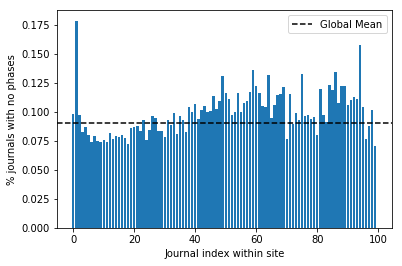

(0.09041722888059898, 0.0981787732886749, 0.17839195979899497)

In [49]:
# 17.8% (props[1] below) of second journal posts are assigned no phases
pct_zero = len(preds[zero_labeling_indices]) / len(preds)
props = []
for ji in range(100):
    pct_zero_and_nth_journal = len(preds[(zero_labeling_indices) & (preds.journal_index == ji)]) / len(preds[preds.journal_index == ji])
    props.append(pct_zero_and_nth_journal)
plt.bar(range(len(props)), props)
plt.axhline(pct_zero, linestyle='--', color='black', label="Global Mean")
plt.xlabel("Journal index within site")
plt.ylabel("% journals with no phases")
plt.legend()
plt.show()
pct_zero, props[0], props[1]

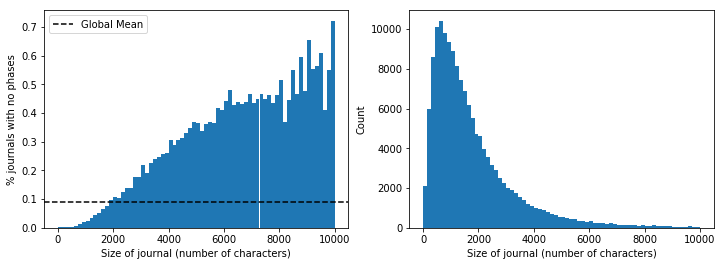

(0.09041722888059898, 0.0019093078758949881, 142)

In [54]:
# investigate the impact of journal length on zero labeling
max_size = 10000

pct_zero = len(preds[zero_labeling_indices]) / len(preds)
props = []
left_edges = []
left_edge = None
for right_edge in np.linspace(0, max_size, 71):
    if left_edge is None:
        left_edge = right_edge
        continue
    total_in_bucket = len(preds[(preds.journal_text_length > left_edge) & (preds.journal_text_length <= right_edge)])
    if total_in_bucket > 0:
        pct = len(preds[(zero_labeling_indices) & (preds.journal_text_length > left_edge) & (preds.journal_text_length <= right_edge)]) / total_in_bucket
    else:
        pct = 0
    props.append(pct)
    left_edges.append(int(left_edge))
    left_edge = right_edge
right_edges = np.linspace(0, max_size, 70)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(axs[0])
plt.bar(left_edges, props, align='edge', width=left_edges[1] - left_edges[0])
plt.axhline(pct_invalid, linestyle='--', color='black', label="Global Mean")
plt.xlabel("Size of journal (number of characters)")
plt.ylabel("% journals with no phases")
plt.legend()

plt.sca(axs[1])
plt.hist(preds.journal_text_length, range=(0, max_size), bins=70, log=False)
plt.xlabel("Size of journal (number of characters)")
plt.ylabel("Count")

plt.show()
pct_invalid, props[0], left_edges[1]

#### Multi-phase analysis

In [40]:
# Compute the percentage of journals that were assigned two phases
two_phase_labelings = np.sum(np.apply_along_axis(lambda row: np.sum(row) == 2, 1, y_pred))
two_phase_labelings / len(preds)

0.08879011561764161

Num journals under consideration: 13330


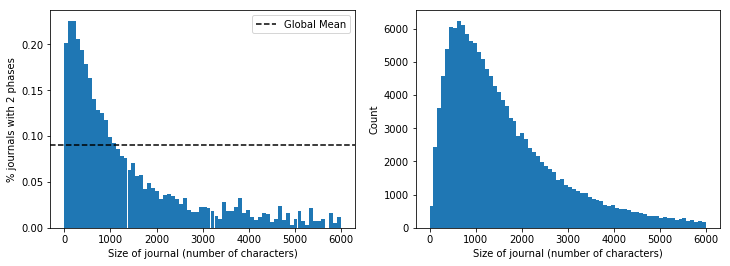

(0.09041722888059898, 0.20212765957446807, 85)

In [60]:
# investigate the impact of journal length on zero labeling
# it appears that shorter journals are much more likely to be assigned exactly two journals
max_size = 6000

two_labeling_indices = np.apply_along_axis(lambda row: np.sum(row) == 2, 1, y_pred)
two_labeling_indices = (two_labeling_indices) & (~invalid_labeling_indices)
print("Num journals under consideration:", len(preds[two_labeling_indices]))
pct_zero = len(preds[two_labeling_indices]) / len(preds)
props = []
left_edges = []
left_edge = None
for right_edge in np.linspace(0, max_size, 71):
    if left_edge is None:
        left_edge = right_edge
        continue
    total_in_bucket = len(preds[(preds.journal_text_length > left_edge) & (preds.journal_text_length <= right_edge)])
    if total_in_bucket > 0:
        pct = len(preds[(two_labeling_indices) & (preds.journal_text_length > left_edge) & (preds.journal_text_length <= right_edge)]) / total_in_bucket
    else:
        pct = 0
    props.append(pct)
    left_edges.append(int(left_edge))
    left_edge = right_edge
right_edges = np.linspace(0, max_size, 70)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(axs[0])
plt.bar(left_edges, props, align='edge', width=left_edges[1] - left_edges[0])
plt.axhline(pct_invalid, linestyle='--', color='black', label="Global Mean")
plt.xlabel("Size of journal (number of characters)")
plt.ylabel("% journals with 2 phases")
plt.legend()

plt.sca(axs[1])
plt.hist(preds.journal_text_length, range=(0, max_size), bins=70, log=False)
plt.xlabel("Size of journal (number of characters)")
plt.ylabel("Count")

plt.show()
pct_invalid, props[0], left_edges[1]

In [41]:
# Compute the percentage of journals that were assigned one phase
one_phase_labelings = np.sum(np.apply_along_axis(lambda row: np.sum(row) == 1, 1, y_pred))
one_phase_labelings / len(preds)

0.7739172421091621

### Invalid transitions

Moved to another notebook.